# Approximationsalgorithmen - Musterlösungen

### 1.a) Golomb Lineal - Datenstruktur, Nachbarschafts- und Bewertungsfunktion

Die einfachste Datenstruktur zur Repräsentation eines Golomb-Lineals ist ein Array, welches beginnend bei 0 in aufsteigender Reihenfolge die Marken des Lineals enthält. Die Größe des Arrays wird durch die gewünschte Ordnung festgelegt. Sind alle Array-Positionen gesetzt, ist das Lineal vollständig. Das letzte Array-Element definiert die aktuelle Länge. Das Golomb Lineal ist gültig, wenn alle Markendifferenzen unterschiedlich sind. 

Zunächst stellt sich die Frage, ob auch ungültige Golomb-Lineale als Kandidaten für die Weiterentwicklung in Frage kommen sollen. In diesem Fall muss die Nachbarschaftsfunktion so gestaltet sein, dass Sie nur gültige Nachbarn generiert. Das wiederum kann sehr aufwendig sein und sich so negativ auf die Laufzeit des Programms auswirken. Auch wird die Nachbarschaft sehr viel kleiner sein wodurch der Algorithmus evtl. sehr schnell ein lokales Maximum findet. Es ist durchaus möglich diese Strategie zu verfolgen, hier wird aber eine andere gewählt.

Für das folgende Programm wird festgelegt, dass ein Kandidat immer vollständig ist und jede Marke stets größer ist als ihr Vorgänger. Die Nachbarschaftsfunktion bestimmt alle Lineale, die sich, unter Einhaltung dieser Prämissen, nur durch Verändern beliebiger Marken um +1 oder -1 bilden lassen. Die Bewertungsfunktion bestimmt die Anzahl der Konflikte und addiert diese zur aktuellen Länge. Die minimale Bewertung wird bei einem minimalen Golomb Lineal erreicht (aber nicht nur dann).

In [3]:
def neighbors(ruler):
    n = len(ruler)  # Anzahl der Marken
    def rec(ruler, i):
        if ruler[i] > ruler[i-1]+1:  # genug Platz zum Vorgänger
            r = ruler[:i]+[ruler[i]-1]+ruler[i+1:] # Stelle i --
            yield r
            if i < n-1: # wenn es nicht die letzte Stelle ist
                yield from rec(r, i+1) # rekursiv weiter
        if ruler[i] < n*n and (i == n-1 or ruler[i] <= ruler[i+1]-1):  # genug Platz zum Nachfolger
            r = ruler[:i]+[ruler[i]+1]+ruler[i+1:] # Stelle i ++
            if i == n-1 or r[i] < r[i+1]: # Nur wenn die Folgestelle größer ist
                yield r # als Nachbar liefern
            if i < n-1: # wenn es nicht die letzte Stelle ist
                yield from rec(r, i+1) # rekursiv weiter
        if i < n-1 and ruler[i-1] < ruler[i]: # wenn Vorgänger nicht gleich
            yield from rec(ruler, i+1) # rekursiv mit unveränderter Stelle i weiter
    yield from rec(ruler, 1)

memo = {} # memoizing
def evaluate(ruler):
    s = str(ruler)
    if s in memo: # wurde schon mal bewertet
        return memo[s] # gespeicherte Bewertung nehmen
    diff = set() # Differenzen
    c = 0 # Anzahl der Konflikte
    for i in ruler: # für jede Markierung
        for j in ruler: # und jede Markierung davor
            if i == j: break
            d = i - j # Differenz berechnen
            if d in diff: # gibt es diese Differenz schon?
                c += 1 # Konflikt zählen
            else:
                diff.add(d) # Differenz merken
    res = 2*c*c+ruler[-1] # 2*c*c >> Fehler verstärken
    memo[s] = res # Ergebnis merken
    return res

r = [0,1,3,4]
print(r,evaluate(r))
print("----------------")
for nb in neighbors(r):
    print(nb,evaluate(nb))


[0, 1, 3, 4] 12
----------------
[0, 2, 3, 4] 12
[0, 2, 4, 5] 7
[0, 2, 3, 5] 13
[0, 1, 2, 4] 12
[0, 1, 2, 3] 21
[0, 1, 2, 5] 7
[0, 1, 4, 5] 13
[0, 1, 3, 5] 7


### 1.b) Golomb Lineal - Hill Climbing

In einem Hill Climbing Algorithmus muss nur unter den Nachbarn nach dem besten Kandidaten gesucht werden. Ist dieser schlechter als der aktuelle Kandidat steht das Ergebnis fest. Anderenfalls wird der bessere Kandidat der gleichen Prozedur unterzogen.

In [7]:
import random

def golombHill(ruler):
    global memo
    memo = {} # Memoizer zurücksetzen
    minEval = evaluate(ruler) # momentan bestes Ergebnis
    while True:
        r = None
        rmin = minEval
        nbs = list(neighbors(ruler)) # Nachbarn ermitteln
        random.shuffle(nbs) # Zufällige Reihenfolge der Nachbarn
        for nb in nbs: # Alle Nachbarn prüfen
            m = evaluate(nb) # Bewertung
            if m < rmin: # besser als momentan bestes Ergebnis
                r = nb # Nachbar übernehmen
                rmin = m # Bewertung übernehmen
        if r: # Es gab eine Verbesserung
            minEval = rmin # als momentan bestes Ergebnis übernehmen
            ruler = r
        else: # Keine Verbesserung >> Ergebnis steht fest
            return (ruler, minEval)

print([0,1,2,3],"\t>>",golombHill([0,1,2,3]))
print([0,5,25,48],"\t>>",golombHill([0,5,25,48]))
print("----------------------------------------")
def randomRuler(n):
    return [0] + sorted(random.sample(range(1,n*n+1),n-1))

for i in range(4,10):
    r = randomRuler(i)
    print(r," >> ",golombHill(r))

[0, 1, 2, 3] 	>> ([0, 2, 5, 6], 6)
[0, 5, 25, 48] 	>> ([0, 2, 5, 6], 6)
----------------------------------------
[0, 2, 9, 12]  >>  ([0, 2, 5, 6], 6)
[0, 3, 4, 7, 18]  >>  ([0, 2, 7, 8, 11], 11)
[0, 2, 7, 11, 18, 35]  >>  ([0, 3, 11, 13, 17, 18], 18)
[0, 12, 14, 17, 26, 29, 48]  >>  ([0, 11, 14, 18, 24, 26, 43], 43)
[0, 16, 26, 27, 29, 46, 57, 59]  >>  ([0, 18, 24, 25, 29, 45, 55, 57], 57)
[0, 4, 11, 17, 34, 38, 44, 75, 78]  >>  ([0, 3, 11, 17, 30, 32, 42, 65, 66], 66)


### 1.c) Golomb Lineal - Plateau Search

Schaut man sich die Zwischenschritte von `golombHill` an wird klar, dass die Bewertungsfunktion nicht optimal für Hill Climbing ist. Es gibt zumeist mehrere Lineale mit der gleichen Bewertung die evtl. weiterverfolgt werden sollten.

In [8]:
def golombPlateau(ruler):
    global memo
    memo = {} # Memoizer zurücksetzen
    minEval = evaluate(ruler) # momentan bestes Ergebnis
    tabu = set() # Tabu-Liste
    while True:
        tabu.add(str(ruler)) # aktuelles Element in Tabu-Liste
        r = None
        rmin = minEval # momentan beste Bewertung
        nbs = list(neighbors(ruler)) # Nachbarn ermitteln
        random.shuffle(nbs) # Zufällige Reihenfolge der Nachbarn
        for nb in nbs: # Alle Nachbarn prüfen
            if str(nb) in tabu:
                continue # Tabu-Nachbarn ignorieren
            m = evaluate(nb) # Bewertung
            if m <= rmin: # besser oder gleich gut
                r = nb # übernehmen
                rmin = m
        if r: # Es gab eine Verbesserung oder einen gleich guten Kandidaten
            minEval = rmin # übernehmen
            ruler = r
        else: # Keine mindestens gleich guter Kandidat mehr
            return (ruler, minEval) # Ergebnis steht fest
        
print([0,1,2,3],"\t>>",golombPlateau([0,1,2,3]))
print([0,5,25,48],"\t>>",golombPlateau([0,5,25,48]))
print("----------------------------------------")
for i in range(4,10):
    r = randomRuler(i)
    print(r," >> ",golombPlateau(r))

[0, 1, 2, 3] 	>> ([0, 2, 5, 6], 6)
[0, 5, 25, 48] 	>> ([0, 4, 5, 7], 7)
----------------------------------------
[0, 1, 4, 6]  >>  ([0, 2, 5, 6], 6)
[0, 8, 9, 14, 22]  >>  ([0, 5, 9, 11, 12], 12)
[0, 1, 13, 26, 29, 34]  >>  ([0, 2, 8, 15, 18, 19], 19)
[0, 10, 11, 14, 15, 27, 29]  >>  ([0, 8, 10, 13, 17, 28, 29], 29)
[0, 5, 13, 15, 20, 36, 53, 58]  >>  ([0, 2, 8, 12, 19, 28, 41, 42], 42)
[0, 9, 13, 15, 19, 54, 63, 69, 76]  >>  ([0, 11, 12, 14, 18, 37, 46, 54, 59], 59)


### 1.d) Golomb Lineal - Threshold Accepting

Mit `golombPlateau` scheinen die Ergebisse besser zu werden. Jedoch wird auch für relative kleine Lineale oft nicht die Lösung gefunden. Durch Threshold Accepting werden die Möglichkeiten des Weiterverfolgens erweitert.

In [9]:
thresholdTA = 8 # Akzeptabler Grenzwert
degradeTA = 0.95 # Absenkung des Grenzwerts
def golombThresholdAccepting(ruler):
    global memo
    memo = {} # Memoizer zurücksetzen
    t = thresholdTA
    curEval = evaluate(ruler) # momentan bestes Ergebnis
    bestEval = curEval
    bestRuler = ruler
    tabu = set() # Tabu-Liste
    while True:
        if curEval < bestEval: # aktueller Kandidat besser?
            bestEval = curEval # übernehmen
            bestRuler = ruler
        tabu.add(str(ruler)) # aktuelles Element in Tabu-Liste
        r = None
        rmin = bestEval+t # + akzeptable Verschlechterung
        if t > 0:
            t *= degradeTA
        nbs = list(neighbors(ruler)) # Nachbarn ermitteln
        random.shuffle(nbs) # Zufällige Reihenfolge der Nachbarn
        for nb in nbs: # Alle Nachbarn prüfen
            if str(nb) in tabu:
                continue # Tabu-Elemente ignorieren
            m = evaluate(nb) # Bewertung
            if m <= rmin: # Besser oder akzeptabel schlechter
                r = nb # übernehmen
                rmin = m
        if r: # besserer oder akzeptabel schlechterer Kandidat
            curEval = rmin # übernehmen
            ruler = r
        else: # Kein akzeptabler Kandidat mehr
            return (bestRuler, bestEval) # Ergebnis steht fest
        
print([0,1,2,3],"\t>>",golombThresholdAccepting([0,1,2,3]))
print([0,5,25,48],"\t>>",golombThresholdAccepting([0,5,25,48]))
print("----------------------------------------")
for i in range(4,10):
    r = randomRuler(i)
    print(r,end=" >> ")
    print(golombThresholdAccepting(r))

[0, 1, 2, 3] 	>> ([0, 1, 4, 6], 6)
[0, 5, 25, 48] 	>> ([0, 2, 5, 6], 6)
----------------------------------------
[0, 2, 4, 16] >> ([0, 1, 4, 6], 6)
[0, 10, 13, 19, 25] >> ([0, 3, 7, 8, 9], 11)
[0, 3, 16, 19, 30, 36] >> ([0, 1, 8, 12, 14, 17], 17)
[0, 8, 16, 22, 27, 30, 33] >> ([0, 4, 9, 15, 22, 23, 25], 25)
[0, 10, 16, 39, 41, 43, 44, 55] >> ([0, 12, 20, 27, 33, 36, 37, 38], 40)
[0, 6, 7, 13, 40, 41, 43, 64, 77] >> ([0, 1, 5, 12, 30, 33, 39, 47, 49], 49)


### 1.e) Golomb Lineal - Simulated Annealing

Die Ergebnisse von `golombThresholdAccepting` kommen dem Minimum meist schon sehr nahe. Je höher die Ordnung des zu suchenden Lineals desto größer wird aber auch die Laufzeit. Simulated Annealing kann dem entgegenwirken indem die Wahrscheinlichkeit für die Akzeptanz von schlechteren Zwischenlösungen sukzessive verringert wird.

In [11]:
import math

def randomNeighbor(ruler): # schneller als alle Nachbarn zu generieren und dann einen auszuwählen
    n = len(ruler)  # Anzahl der Marken
    nb = None
    while not nb: # solange noch kein gültiger Nachbar gefunden wurde
        add = [0]+[random.choice([-1,0,1]) for _ in range(1, n)] # Array mit zufälligen Summanden
        nb = [ruler[i]+add[i] for i in range(n)] # zum aktuellen Lineal addieren
        if nb == ruler: # Summanden waren alle 0 = Ausgangs-Lineal
            nb = None # nicht als Nachbar zulässig
            continue
        for i in range(1,n): # Alle Stellen prüfen
            if nb[i] <= nb[i-1]: # nicht größer als der Vorgänger
                nb = None # ungültiges Lineal
                break
    return nb

randomNeighbor([0, 13, 22, 24, 25])

cooling = 0.9995 # Faktor der Abkühlung
errFunc = lambda e : e**3 # Funktion zur Manipulation des Fehlers
def golombSimulatedAnnealing(ruler):
    global memo
    memo = {} # Memoizer zurücksetzen
    bestEval = evaluate(ruler) # momentan bestes Ergebnis
    bestRuler = ruler
    current = ruler
    currentEval = bestEval
    temp = 1000 # Anfangs-"Temperatur" 
    while temp > 0.1: # solange die Ziel-"Temperatur" nicht erreicht ist
        nb = randomNeighbor(current) # einen zufälligen Nachbar wählen
        nbEval = evaluate(nb) # Bewertung
        # besser oder zufällig ist die Verschlechterung momentan noch erlaubt
        if nbEval <= currentEval or math.exp(-errFunc(nbEval-currentEval)/temp) > random.random():
            current, currentEval = nb, nbEval # Kandidat übernehmen
        if currentEval < bestEval: # Besser als momentan bestes Ergebnis
            bestRuler, bestEval = current, currentEval # übernehmen
        temp *= cooling # "Abkühlung"
    return (bestRuler, bestEval) # Tiefst-"Temperatur" erreicht >> Ergebnis steht fest

print([0,1,2,3],"\t>>",golombSimulatedAnnealing([0,1,2,3]))
print([0,5,25,48],"\t>>",golombSimulatedAnnealing([0,5,25,48]))
print("----------------------------------------")
for i in range(4,10):
    r = randomRuler(i)
    print(r,end=" >> ")
    print(golombSimulatedAnnealing(r))

[0, 1, 2, 3] 	>> ([0, 1, 4, 6], 6)
[0, 5, 25, 48] 	>> ([0, 2, 5, 6], 6)
----------------------------------------
[0, 3, 5, 10] >> ([0, 1, 4, 6], 6)
[0, 6, 7, 21, 22] >> ([0, 2, 7, 10, 11], 11)
[0, 3, 6, 7, 13, 15] >> ([0, 2, 7, 13, 16, 17], 17)
[0, 18, 22, 33, 42, 45, 47] >> ([0, 1, 4, 12, 18, 20, 25], 27)
[0, 5, 13, 21, 25, 27, 40, 42] >> ([0, 3, 7, 25, 30, 31, 39, 41], 41)
[0, 17, 26, 27, 28, 36, 60, 66, 67] >> ([0, 12, 25, 27, 35, 49, 65, 66, 70], 72)


### 1.f) Analyse der Parameter - Vergleich der Algorithmen


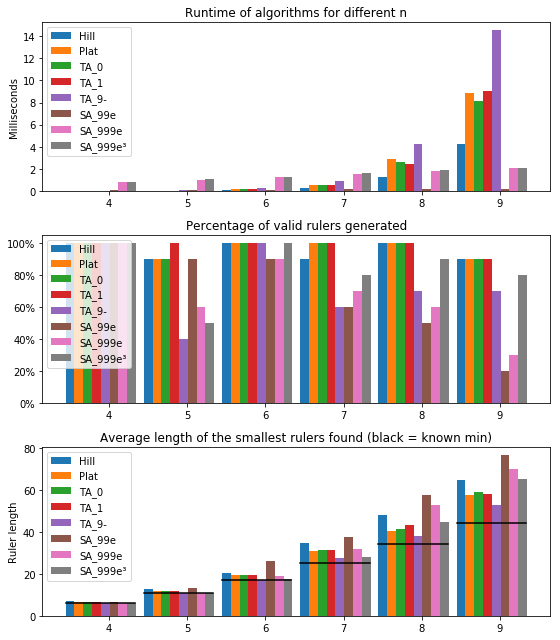

In [369]:
import time
import matplotlib.pyplot as plt

def setTA(t,d): # Setzen der Parameter für Threshold Accepting
    global thresholdTA, degradeTA
    thresholdTA = t
    degradeTA = d
    
def setSA(c,e): # Setzen der Parameter für Simulated Annealing
    global cooling, errFunc
    cooling = c
    errFunc = e
    
tests = [ # durchzuführende Test
    ("Hill", golombHill, None), # (Name, Funktion, Vorbereitungsfunktion)
    ("Plat", golombPlateau, None),
    ("TA_0", golombThresholdAccepting, lambda: setTA(0,1)),
    ("TA_1", golombThresholdAccepting, lambda: setTA(1,1)),
    #("TA_2", golombThresholdAccepting, lambda: setTA(2,1)),
    #("TA_5", golombThresholdAccepting, lambda: setTA(5,1)),
    ("TA_9-", golombThresholdAccepting, lambda: setTA(9,0.999)),
    ("SA_99e", golombSimulatedAnnealing, lambda: setSA(0.99, lambda e : e)),
    #("SA_99e²", golombSimulatedAnnealing, lambda: setSA(0.99, lambda e : e*e)),
    #("SA_99e³", golombSimulatedAnnealing, lambda: setSA(0.99, lambda e : e**3)),
    ("SA_999e", golombSimulatedAnnealing, lambda: setSA(0.999, lambda e : e)),
    #("SA_999e²", golombSimulatedAnnealing, lambda: setSA(0.999, lambda e : e*e)),
    ("SA_999e³", golombSimulatedAnnealing, lambda: setSA(0.999, lambda e : e**3)),
    #("SA_9995e", golombSimulatedAnnealing, lambda: setSA(0.9995, lambda e : e)),
    #("SA_9995e²", golombSimulatedAnnealing, lambda: setSA(0.9995, lambda e : e*e)),
    #("SA_9995e³", golombSimulatedAnnealing, lambda: setSA(0.9995, lambda e : e**3))
]

def runTest(n, numOfRuns):
    times = [0 for _ in range(len(tests))]
    valid = [0 for _ in range(len(tests))]
    sumV = [0 for _ in range(len(tests))]
    for i in range(numOfRuns):
        ruler = randomRuler(n) # Ausgangslineal bestimmen
        for j in range(len(tests)):
            (name, func, prepare) = tests[j] # Test-Spezifikation
            if prepare: prepare() # Vorbereitung (Parameter setzen)
            tstart = time.time()
            (r, rEval) = func(ruler) # Ausführung
            times[j] += time.time()-tstart # Zeit loggen
            if r[-1] == rEval: # ein gültiges Lineal
                valid[j] += 1 # zählen
                sumV[j] += rEval # Länge summieren
    return (times, 
            [sumV[i]/valid[i] if valid[i] > 0 else 0 for i in range(len(tests))],
            [valid[i]/numOfRuns for i in range(len(tests))])

ntest = list(range(4,10)) # Die Test Ordnungen
repeat = 10 # Test so oft wiederholen
testtimes = [[] for _ in tests]
testvalid = [[] for _ in tests]
testavg = [[] for _ in tests]
for n in ntest: # Für jede Ordnung
    (times, avgValid, valid) = runTest(n, repeat) # Test ausführen
    for ti in range(len(tests)): # Ergebnisse pro Testspezifikation
        testtimes[ti].append(times[ti]) # Laufzeiten
        testvalid[ti].append(valid[ti]) # Prozent gültig
        testavg[ti].append(avgValid[ti]) # Mittlere gefundene Länge

plt.rcParams["figure.figsize"] = (8,9)
w = 0.9/len(tests)

f,plots = plt.subplots(nrows=3)
timeplot = plots[0]
for ti in range(len(tests)): # Balken pro Test und Ordnung
    timeplot.bar([i+ti*w for i in range(len(ntest))], testtimes[ti], label=tests[ti][0], width=w)
timeplot.set_xticks([i+0.5 for i in range(len(ntest))])
timeplot.set_xticklabels([n for n in ntest])
timeplot.set_ylabel("Milliseconds")
timeplot.set_title("Runtime of algorithms for different n")
timeplot.legend(loc="upper left")

validplot = plots[1]
for ti in range(len(tests)): # Balken pro Test und Ordnung
    validplot.bar([i+ti*w for i in range(len(ntest))], testvalid[ti], label=tests[ti][0], width=w)
validplot.set_xticks([i+0.5 for i in range(len(ntest))])
validplot.set_xticklabels([n for n in ntest])
validplot.set_yticklabels(['{:,.0%}'.format(x) for x in validplot.get_yticks()])
validplot.set_title("Percentage of valid rulers generated")
validplot.legend(loc="upper left")

mg=[0,1,3,6,11,17,25,34,44,55,72,85,106,127,151,177,199,216,246,283]
avgplot = plots[2]
for ti in range(len(tests)): # Balken pro Test und Ordnung
    avgplot.bar([i+ti*w for i in range(len(ntest))], testavg[ti], label=tests[ti][0], width=w)
for i in range(len(ntest)): # Bekannte Minimallängen als schwarze Linien
    avgplot.plot([i-w/2,i+1-1.5*w], [mg[ntest[i]-1], mg[ntest[i]-1]],color="black")
avgplot.set_xticks([i+0.5 for i in range(len(ntest))])
avgplot.set_xticklabels([n for n in ntest])
avgplot.set_ylabel("Ruler length")
avgplot.set_title("Average length of the smallest rulers found (black = known min)")
avgplot.legend(loc="upper left")

plt.tight_layout()

Die Laufzeit von Threshold Accepting steigt am stärksten und die von Simulated Annealing mit Abstand am wenigsten.

Die Verlässlichkeit gültige Lineale zu finden, scheint beim Setzen engerer Grenzwerte (Hill Climbing, Plateau Search, Threshold Accepting mit kleiner Toleranz) höher zu sein. Bei Simulated Annealing hat die Bewertung von Fehlern einen starken Einfluss auf die Verlässlichkeit.

Mit zunehmender Ordnung wird bei allen Algorithmen häufiger nicht das minimale Golomb Lineal gefunden. Threshold Accepting (mit sich absenkendem Grenzwert) hat im Schnitt die kürzeren gültigen Lineale gefunden.

### 2) Golomb Lineale mit genetischem Algorithmus

Beim k-point-crossover werden k+1 Teile der *Eltern* **vertauscht** um so die *Kinder* zu erzeugen. Ohne Mutation entstehen im Golomb-Lineal niemals Markenwerte, die nicht in irgendeinem Lineal der Basispopulation bereits an dieser Position vorkommen. Es ist also eine entsprechend große Basispopulation erforderlich.

Bei Kreuzung zweier identischer Lineale erzeugt k-point-crossover keine neuen Lineale. Die Gefahr, dass die Selektion der Besten solche Lineale enthält ist recht groß. Es sollte also vermieden werden, dass sich identische Lineale in der Basispopulation befinden.

Mutation sollte nur in einem geringen Maße auftreten, da sonst rein zufällige *Kinder* entstehen. In diesem Programm wird nur eine einzige Marke um nur 1 verringert. Ob Mutation im speziellen Fall überhaupt auftritt, wird einer einstellbaren Wahrscheinlichkeit unterworfen.

In [136]:
def isAscending(r): # Sind die Marken aufsteigend
    for i in range(len(r)-1):
        if r[i] >= r[i + 1]:
            return False
    return True

print("IsAscending?", [0,1,3,3,5], ">>", isAscending([0,1,3,3,5]))

def crossover(ra, rb, k):  # k-point-crossover mit den beiden "Eltern" und k
    rc1, rc2 = [], []  # Die "Kinder"
    last = 0
    for i in sorted(random.sample(range(1, len(ra)), k)):  # an jedem crossover
        rc1 += ra[last:i]  # bis zum crossover übernehmen
        rc2 += rb[last:i]
        last = i  # letzten crossover merken
        ra, rb = rb, ra  # "Eltern" tauschen
    rc1 += ra[last:]  # übriges übernehmen
    rc2 += rb[last:]
    return rc1, rc2

print("2-point-crossover:",crossover([0,1,3,5,7,9],[0,2,4,6,8,10],2))

def mutate(r,p):
    if random.random() < p: # tritt zufällig eine Mutation auf
        i = random.randint(1,len(r)-1) # Stelle zufällig wählen
        r[i] -= 1 # die Mutation: Marke um 1 verringern
    return r

print("Mutate 90%:",[0,1,3,5,7,9],mutate([0,1,3,5,7,9],0.9))



IsAscending? [0, 1, 3, 3, 5] >> False
2-point-crossover: ([0, 1, 3, 6, 8, 9], [0, 2, 4, 5, 7, 10])
Mutate 90%: [0, 1, 3, 5, 7, 9] [0, 0, 3, 5, 7, 9]


(35, [0, 1, 9, 13, 19, 30, 33, 35])


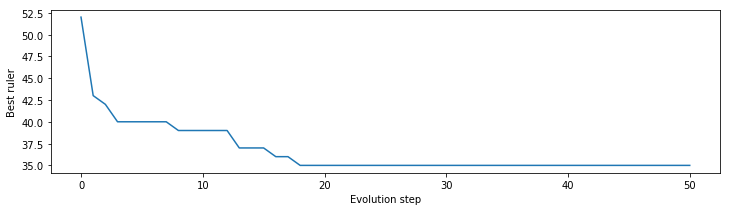

In [138]:
import heapq

def golombGenetic(n, iterations, size, select, recomb, k, pmutate):
    global memo
    memo = {}  # Memoizer zurücksetzen
    evo = [] # log
    # zufällige Basispopulation von Linealen generieren
    population = []
    popkeys = set()
    i = size
    while i > 0:
        r = randomRuler(n)
        if str(r) in popkeys:
            continue # keine identischen Lineale
        popkeys.add(str(r))
        i -= 1
        population.append((evaluate(r), r))
    heapq.heapify(population)  # sortiert nach Bewertung
    best = heapq.nsmallest(1, population)[0]  # momentan bestes Lineal
    evo.append(best[0])
    for i in range(iterations):  # Evolutionsschritte
        A = heapq.nsmallest(select, population)  # die Besten
        for a in A:
            for b in A:
                if a == b:
                    break  # für jedes Paar der Selektion
                for _ in range(recomb):  # neue Situation rekombinieren
                    # k-point-crossover
                    rc1, rc2 = crossover(a[1],b[1],k)
                    # Mutation
                    rc1 = mutate(rc1,pmutate)
                    rc2 = mutate(rc2,pmutate)
                    # Zur Population hinzufügen wenn möglich
                    if isAscending(rc1) and str(rc1) not in popkeys:
                        c = evaluate(rc1)
                        if c < best[0]:  # gab es Verbesserungen
                            best = (c, rc1)
                        popkeys.add(str(rc1))
                        heapq.heappush(population, (c, rc1))
                    if isAscending(rc2) and str(rc2) not in popkeys:
                        c = evaluate(rc2)
                        if c < best[0]:  # gab es Verbesserungen
                            best = (c, rc2)
                        popkeys.add(str(rc2))
                        heapq.heappush(population, (c, rc2))
        evo.append(best[0])
        # Auswahl der "Überlebenden"
        population = heapq.nsmallest(size, population)
        popkeys = set([str(p[1]) for p in population])
    return best, evo

steps = 50
best,evo = golombGenetic(8, steps, 500, 100, 2, 2, 0.5)
print(best)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,3)
ax = plt.subplot()
ax.plot(range(0,steps+1), evo)
ax.set_ylabel("Best ruler")
x = ax.set_xlabel("Evolution step")